## Census Income Classification

#### Source: http://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/ | Date: 12/07/18 

#### Overview
Utilizing data obtained from UCI Machine Learning Repository, the goal of this project is to build a predictive model that can classify the correct income-level category for people in the US using various features found in Census data.

It's a binary class, supervised classification problem. However, it's also an IMBALANCED dataset. The main interest of the analysis in this notebook is to deal with class imbalances in a dataset (when one of the classes is much more prevalent than the other).

#### The following code provides the option of hiding all code when viewed in nbviewer.

In [1]:
from IPython.display import HTML

HTML('''<script>code_show=true; function code_toggle() {if (code_show){$('div.input').hide();} else {
 $('div.input').show();}code_show = !code_show} $( document ).ready(code_toggle);</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## 1. Load Libraries and Datasets
#### Load libraries

In [2]:
# General
import warnings
from datetime import datetime
from datetime import timedelta
import os

# Data Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from PIL import Image

# Feature and Model Selection
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold

# Neural Networks
from keras.models import Model
from keras import Input, layers

# Random Forests
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# XGBoost
import xgboost as xg
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# SVM
from sklearn.svm import SVC

# Model Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score

C:\Users\dbejarano\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Load train datasets and sample submission file already saved in directory. Below are the first few rows for each.

In [3]:
# Load Datasets
train_df_original = pd.read_csv('train.csv')
test_df_original = pd.read_csv('test.csv')

# Copy loaded Datasets
train_df = train_df_original.copy()
test_df = test_df_original.copy()

# Visualize Datasets as Tables
display(train_df.head(3))
print('Training Set Size: ', train_df.shape)
display(test_df.head(3))
print('Test Set Size: ', test_df.shape)

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_lastwk,marital_status,major_industry_code,major_occupation_code,...,country_father,country_mother,country_self,citizenship,business_or_self_employed,fill_questionnaire_veteran_admin,veterans_benefits,weeks_worked_in_year,year,income_level
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,-50000
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,-50000
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,-50000


Training Set Size:  (199523, 41)


,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_lastwk,marital_status,major_industry_code,major_occupation_code,...,country_father,country_mother,country_self,citizenship,business_or_self_employed,fill_questionnaire_veteran_admin,veterans_benefits,weeks_worked_in_year,year,income_level
0,38,Private,6,36,1st 2nd 3rd or 4th grade,0,Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,...,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,0,Not in universe,2,12,95,-50000
1,44,Self-employed-not incorporated,37,12,Associates degree-occup /vocational,0,Not in universe,Married-civilian spouse present,Business and repair services,Professional specialty,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,26,95,-50000
2,2,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,-50000


Test Set Size:  (99762, 41)


### Datasets Description

#### Some of the Features:
- Age
- Marital Status
- Income
- Family Members
- No. of Dependents
- Tax Paid
- Investment (Mutual Fund, Stock)
- Return from Investments
- Education
- Spouse Education
- Nationality
- Occupation
- Region in US
- Race
- Occupation category
- ...

#### Training Set:
Contains 199K observations of 41 features providing information about individuals living in the US. Our goal is to classify income_level accurately. 


#### Test Set:
Contains 99K observations of the same 41 features as above.

## 2. Exploratory Data Analysis

### Null Values
Let's look at how many missing values are in the data and determine how to deal with them.

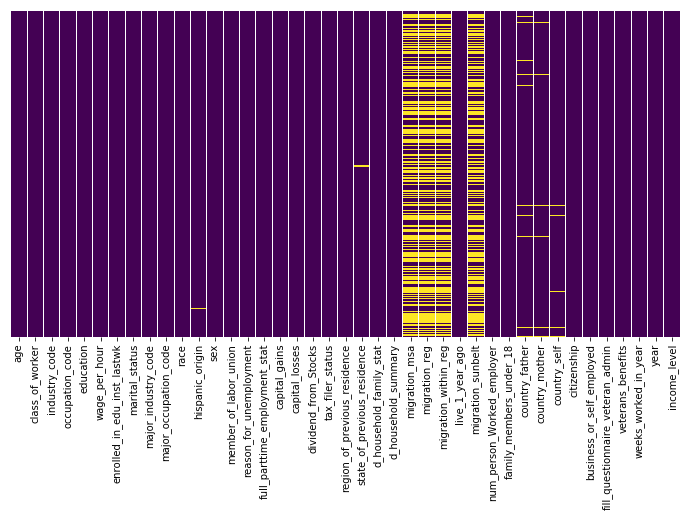

In [4]:
# Plot Missing Values
fig = plt.figure(figsize=(12, 6))
sns.heatmap(train_df.isnull(), yticklabels=False, cbar=False, cmap='viridis') 

#### Feature Engineering 1 - Drop Missing Value Columns and Impute/Drop Missing Value Rows
As it can be observed, various features have half of its data missing. We can either drop those columns or keep them. If we keep them we deal with the missing values in one of two ways: 1) drop the rows where they have missing values, which reduces our training set from 199K to 99K observations, and 2) replace missing values in such columns with the most frequent, median or average value for that particular feature. The cell after the one below shows the three options. 

Per the 3 plots below we can see how income_level relates to the caterogies in migration_msa, migration_reg and migration_sunbelt. My intuition is that these three variables will not be important to our model. Therefore, for the purposes of our EDA, so we get a full picture of the data without losing about half of it (which is what would happen if we dropped all rows with missing values in the migration variables), we will drop the migration variables. However, when it comes time to train our model we will try both with and without those variables.

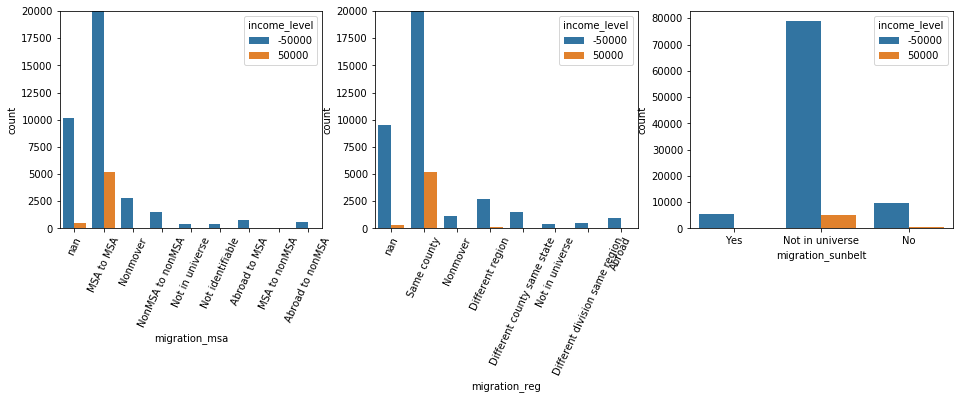

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

g0 = sns.countplot('migration_msa', data=train_df, hue='income_level', ax=axes[0])
g0.set_xticklabels(rotation=65, labels=train_df['migration_msa'].unique())
g0.set_ylim(0, 20000)

g1 = sns.countplot('migration_reg', data=train_df, hue='income_level', ax=axes[1])
g1.set_xticklabels(rotation=65, labels=train_df['migration_reg'].unique())
g1.set_ylim(0, 20000)

sns.countplot('migration_sunbelt', data=train_df, hue='income_level', ax=axes[2])

In [6]:
train_df = train_df_original.copy()
feats_missing_data = ['migration_msa', 'migration_reg', 'migration_within_reg','migration_sunbelt']

#Option 1 - Drop Features with a large amount of missing values
train_df.drop(feats_missing_data, inplace=True, axis=1)

# # Option 2 - Impute Values with Most Frequent Ones
# train_df = train_df.apply(lambda x: x.fillna(x.value_counts().index[0]))

# Option 3 - Drop Rows with Missing Values
# train_df.dropna(inplace=True, axis=0)

# Drop rows that still have missing data
train_df.dropna(inplace=True, axis=0)
print('Shape of Resulting DataFrame: {}'.format(train_df.shape))

Shape of Resulting DataFrame: (189729, 37)


#### Feature Engineering 2 - Replace Target Variable values with 0 for below 50,000 and 1 for above 50,000

In [7]:
train_df['income_level'] = train_df['income_level'].map({-50000:0, 50000:1})

### PLOTS & PLOTS
The best model will be the one that uses the least amount of features to capture the most amount of variance in the response variable income_level. Understanding how income_level relates to other variables is therefore the first step in understanding what the best model might look like. Below we will create a series of plots to provide us with insights of which features may have the most explanatory value. 

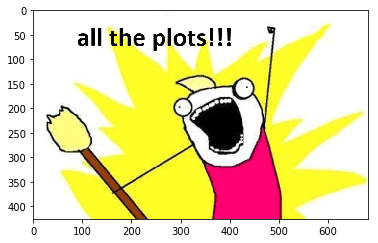

In [8]:
# Plot "all the plots image"
img = Image.open("all the plots.png")
img_data = np.asarray(img)
plt.imshow(img_data)

#### Plot pairs of numerical variables
We won't be running the actual pairplot code since it takes very long and did not provide much information. Instead we will create plots specific to the different features available.

In [9]:
# sns.pairplot(train_df)
# plt.savefig('pairplot.png')

### Income Level

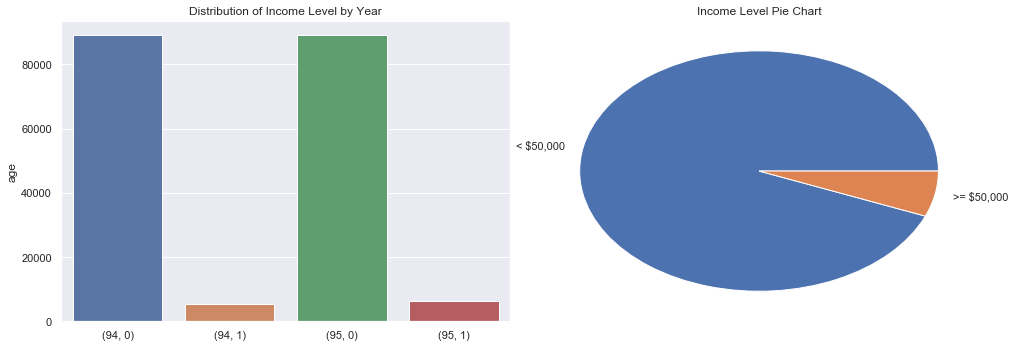

In [10]:
sns.set()

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14, 5)

# Plot by year
grouped_year_income = train_df.groupby(['year', 'income_level']).count()
sns.barplot(x=grouped_year_income.index, y=grouped_year_income['age'], ax=axes[0])
axes[0].set(title='Distribution of Income Level by Year')

axes[1].pie(train_df['income_level'].value_counts(), labels=['< $50,000', '>= $50,000'])
axes[1].set(title='Income Level Pie Chart')

plt.tight_layout()

#### Analysis:

The plots above clearly show this is an imbalanced dataset, with most of the observations belonging to the income_level < $50,000. We can also see that the distribution does not vary from the year 1994 to 1995. For that reason, we will drop this variable from our dataset.

### Distribution of income_level Across Various Features

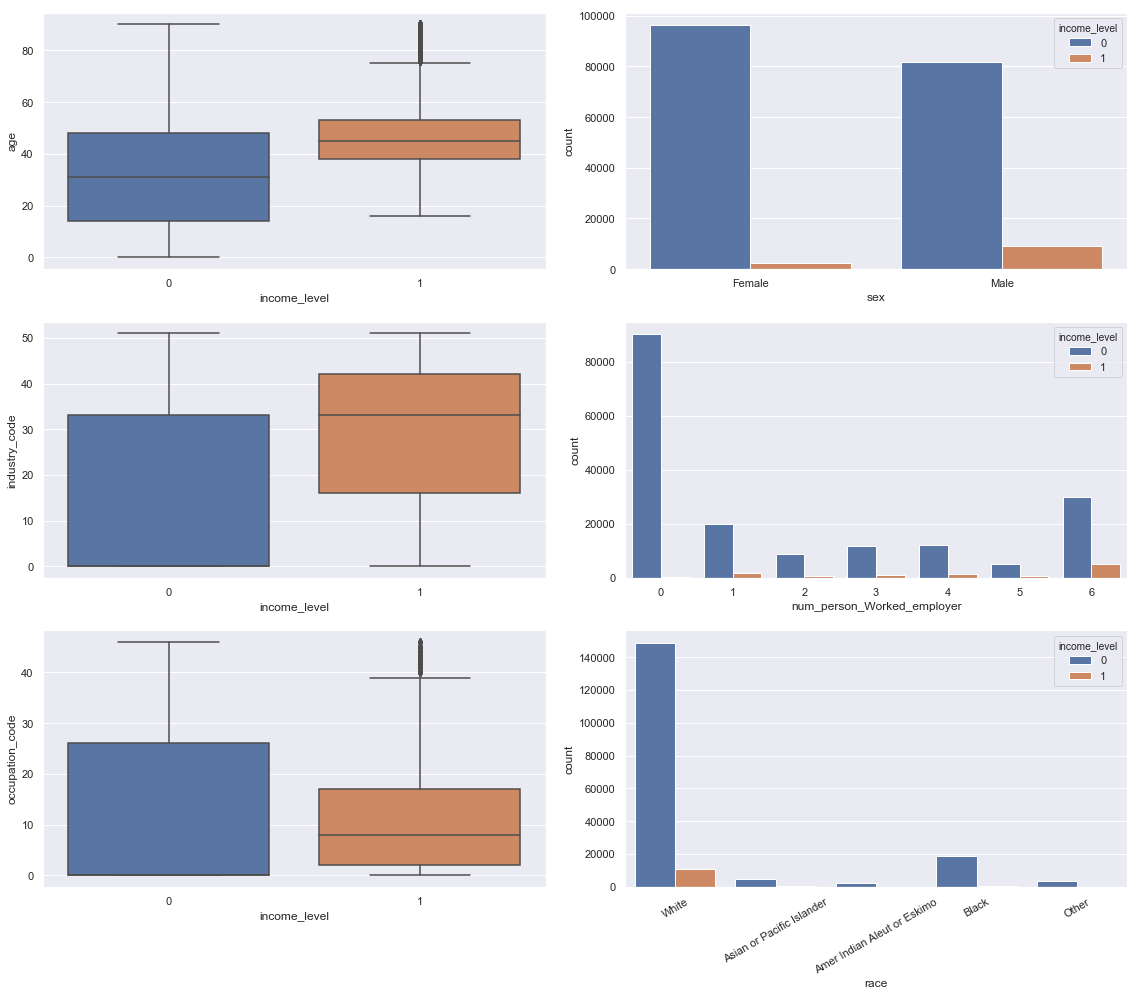

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(16, 14)

sns.boxplot(y='age', x='income_level', data=train_df, ax=axes[0][0])

sns.countplot('sex', data=train_df, hue='income_level', ax=axes[0][1])

sns.boxplot(y='industry_code', x='income_level', data=train_df, ax=axes[1][0])

sns.countplot('num_person_Worked_employer', data=train_df, hue='income_level', ax=axes[1][1])

sns.boxplot(y='occupation_code', x='income_level', data=train_df, ax=axes[2][0])

g6 = sns.countplot(train_df['race'], data=train_df, hue='income_level', ax=axes[2][1])
g6.set_xticklabels(rotation=30, labels=train_df['race'].unique())

plt.tight_layout()

#### Analysis:
Several of the features plotted above capture observable variance in income_level. Most notably:
1. There is a tendency for income_level to increase with age. We will look at this in more detail next.
2. There are more females in this census data than males. Also, a greater proportion of males earn above 50,000 compared to the proportion of women. Does this mean men are being paid more than women? Before we get political, let's investigate this more closely later in this analysis.
3. The higher the industry code, the higher the expected salary.
4. I'm not completely sure what the num_person_Worked_employer variable represents, but we do observe some of its values having a larger proportion of >50000 values.
5. occupation_code does not show much of a trend to determine whether the income_level is above or below 50,000
6. The great majority of people earning above 50,000 are white.

### Income Level as a Function of Age
Let's analyze how income_level varies with age.

[Text(0.5,1,'Wage Per Hour vs Age')]

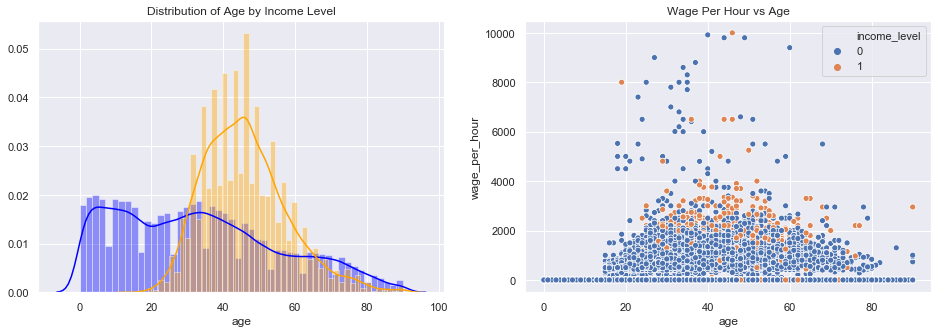

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 5)

sns.distplot(train_df['age'][train_df['income_level']==0], color='blue', ax=axes[0])
sns.distplot(train_df['age'][train_df['income_level']==1], color='orange', ax=axes[0])
axes[0].set(title='Distribution of Age by Income Level')

sns.scatterplot(y='wage_per_hour', x='age', data=train_df, hue='income_level', ax=axes[1])
axes[1].set(title='Wage Per Hour vs Age')

#### Analysis:
As previously observed, income level distributions for >50000 is very different to that for <50000. We can see from the graph on the left that most people earning above 50000 are between3 30 and 55 years old.

We can also observe that, not too surprisingly, people under 20 earn excusively less than 50000. 

### Women and Men Earnings
As mentioned above, let's look into the distribution of income for men and women to determine if men are being paid more.

Our first plot below shows the distribution of age for both men and women. We can see they are almost identical. Meaning, we can't attribute the difference in salary to the population of men falling mostly in the range we identified as the high-earnings period. 

The second plot (violing plot) shows the distribution of weeks worked in a year by men and women. We will discuss this in the next section.

Maybe the difference is in which types of industries men and women work? Let's see.

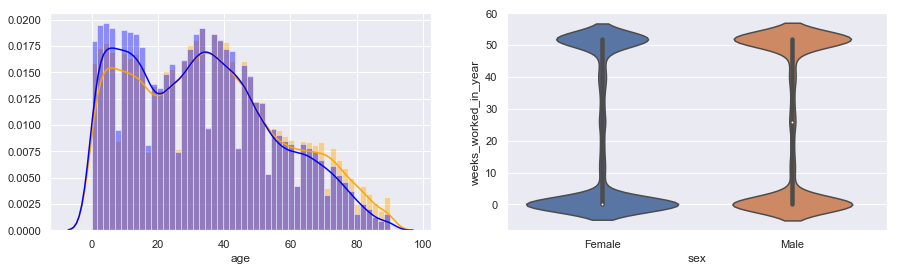

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 4)

sns.distplot(train_df['age'][train_df['sex']=='Female'], color='orange', ax=axes[0])
sns.distplot(train_df['age'][train_df['sex']=='Male'], color='blue', ax=axes[0])

sns.violinplot(y='weeks_worked_in_year', x='sex', data=train_df, ax=axes[1])

The plots below look at variations between industries.

The first plot shows the the number of people that work at each industry. Since industry #0 has been cut, know that its values are 55,000 women and around 42,000 males. 

The second plot shows the average income level per industry. We notice that only one industry has an average higher than 0.5, which is expected, as we have seen how most people earn under 50000 dollars.

A reasonable theory for why men show to be earning more than women is that men work in industries that pay more. From plot 1 below we see that there are definitely differences in the amount of men vs women from one industry to another. However, we can see on the second plot that there is no systematic trend for more women to work on high-paying industries. In fact, plot 2 clearly shows that there is not a single industry in which women are paid more on average than men. 

Before concluding that men are arbitrarily paid more than women, with no basis on objective criteria, let's look at other variables that could influence the discrepancy in salary. The first is the number of weeks worked in a year. As shown above, a greater proportion of women work less than 10 weeks per year, compared to men. However, if we get the average income_level per industry and divide it by the number of weeks worked (so that we get the average income_level per week worked) we would see that the discrepancy discussed above still exists. I did not include the graph showing this, but I did look at it myself.

Another factor to explain the discrepancy is education levels. From plots 3 and 4 below we see that although the distribution of education levels for men and women is almost identical, the average income_level for all education levels is higher for men.

At this point, and although there are likely other factors that would explain part of the observed wage-gap, it can be concluded that from this dataset, a larger proportion of men are paid above 50,000 dollars per year as compared to women.

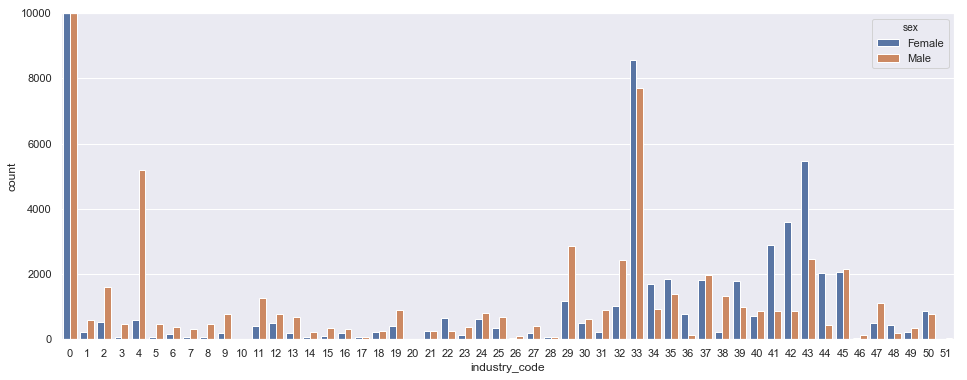

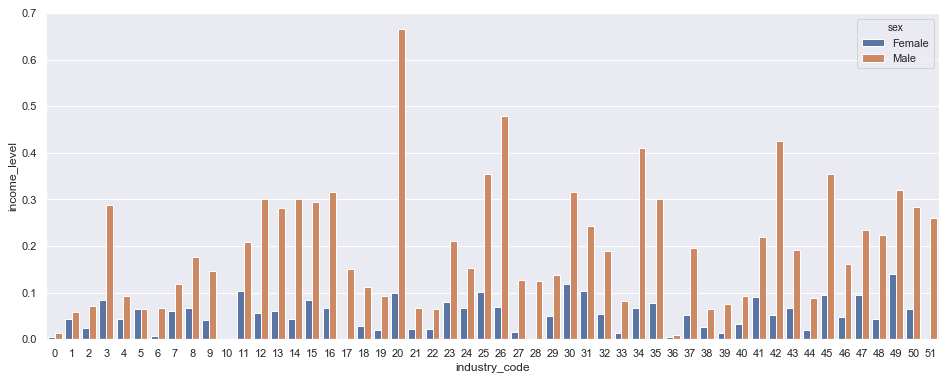

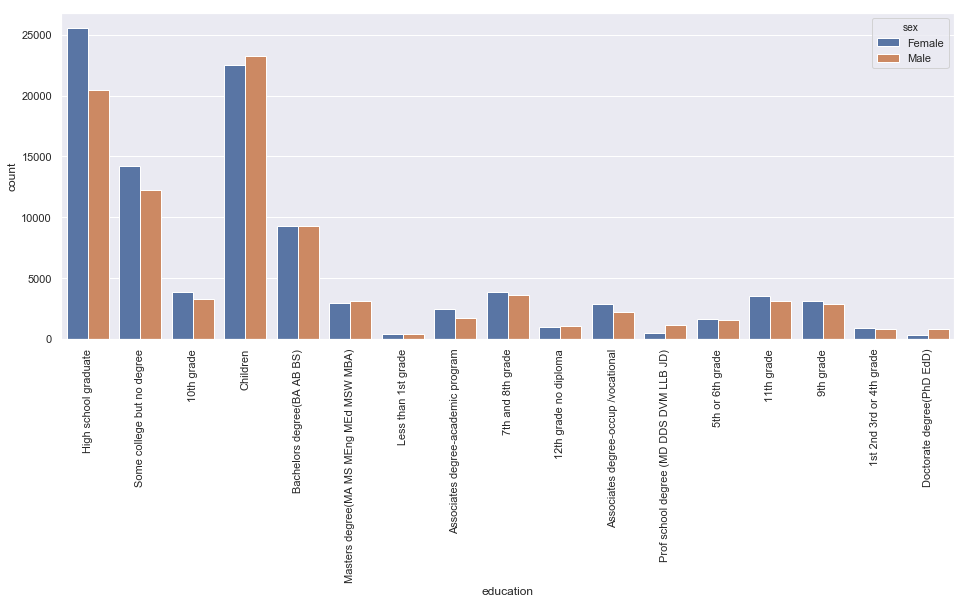

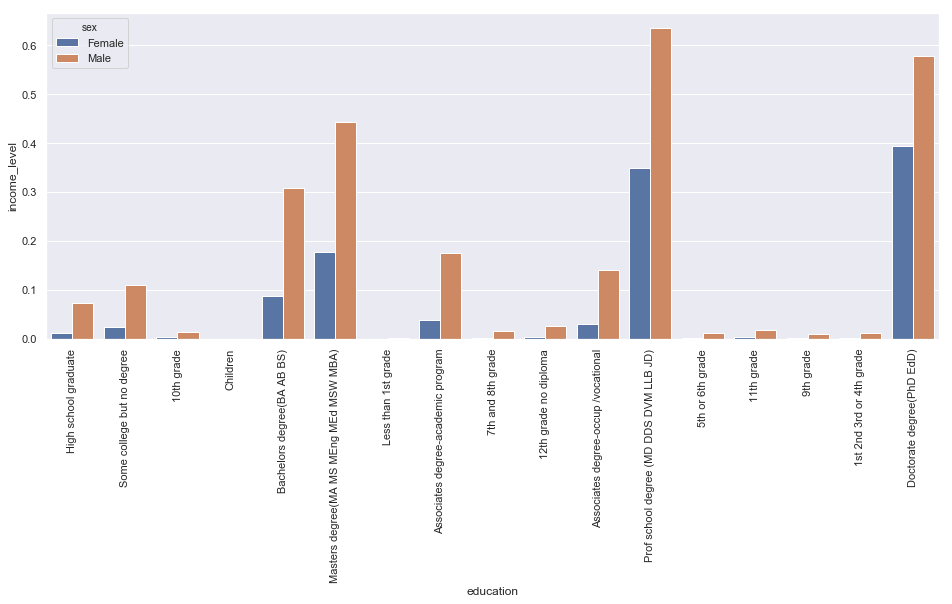

In [14]:
fig = plt.figure(figsize=(16, 6))
g1 = sns.countplot(train_df['industry_code'], hue=train_df['sex'])
g1.set_ylim(0, 10000)

fig = plt.figure(figsize=(16, 6))
g2 = sns.barplot(x='industry_code', y='income_level', data=train_df, hue=train_df['sex'], ci=None)

fig = plt.figure(figsize=(16, 6))
g3 = sns.countplot(train_df['education'], hue=train_df['sex'])
g3.set_xticklabels(rotation=90, labels=train_df['education'].unique())

fig = plt.figure(figsize=(16, 6))
g4 = sns.barplot(x='education', y='income_level', data=train_df, hue=train_df['sex'], ci=None)
g4.set_xticklabels(rotation=90, labels=train_df['education'].unique())
print()

### Correlation
As a final step in our EDA, let's look at a correlation matrix for numerical variables to get a full picture of the linear relationships in the data.

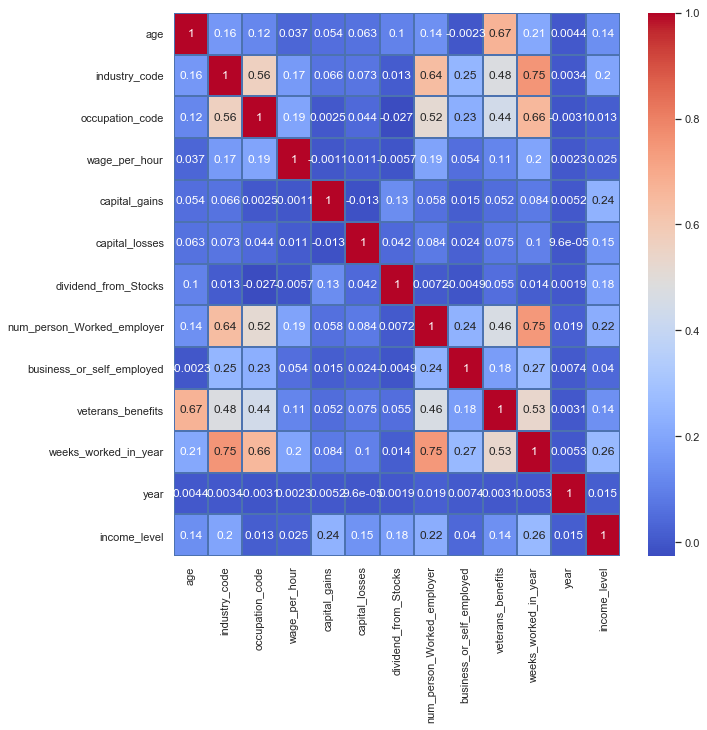

In [15]:
train_df = train_df_original.copy()
fig = plt.figure(figsize=(10, 10))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm', linecolor='b', linewidth=1)

#### Analysis:
The correlation heatmap above will help us determine that some variables can be dropped as they are highly correlated with other variables. An example would be weeks_worked_in_year, as it is highly correlated with industry_code, occupation_code, and num_person_Worked_employer. We might even drop one of these latter variables as well. Veterans benefits is highly correlated with age, so it will also be droped.

**There are other interesting relationships we could explore further as part of our EDA. However, at this point we have a solid understanding of the data and will proceed to develop and train our models that will allow us to classify observations as either under or over 50,000 dollars of income. But first, let's consolidate and run the pre-processing functions we will need to take our original data to a format that can be fed into our models.**

## 3. Data Preprocessing

The following two cells of code define and run the functions we need to preprocess our data. It includes the steps below. Note that not all of the steps included below are necessary. The final choice of which data preprocessing steps to take and which to disregard was based on experience and trial & error for this particular problem.
1. **Drop variables with missing values -**  As discussed above, the "migration" variables had many NaN values and did not help produce a better model. They were therefore dropped.
2. **Drop uninportant features -** There are two main approaches: 
    - (1) An iterative, ad-hoc methodology where variables are closely looked at to determine which ones add to our model's predictive power. Using this methodology I first removed some variables that were highly correlated with the response variable or amongst themselves (to avoid colinearity). However, I then tried a different approach that yielded better results... 
    - (2) A systematic methodology that left all variables to begin with, and later removed those with low predictive power using two steps: first, those variables with a low variance (say, lower than 0.01) were removed; second, once a model had been trained (e.g. Random Forests) we call the feature_importanes_ method to get an importance score for each feature. Based on that score, only the top __ were chosen (I leave that blank because the number of features chosen changes from model to model).
3. **Drop instances of categorical variables with low representation -** Some categorical features contained a class that is only present in 10 observations or less. That low level of representation can hinder our ability to accurately predict on the test set (for instance, if those classes do not appear at all on the test set). We are therefore dropping observations containing such classes. Other than leaving them in, an alternative is to impute their values. 
3. **Impute Missing Values -** As mentioned previously, since there are only a few observations with missing values once we remove the "migration variables", we replace their values with the their feature's most frequent value.
4. **Drop rows with missing values -** This is an alternative to the step above. 
5. **Map income_level to 0s and 1s -** To get our target variable in a form that is easier to manipulate and interpret
6. **Normalize and scale continuous variables -** This was done by making the mean of each feature equal to zero, and dividing by one standard deviation. This assumes that variables are normally (or near normal) distributed, which is not the case for all of them. A more robust approach would be to transform each feature based on its underlying distribution.
7. **Shuffle Training Set -** to prevent the model from learning any structure from the way the data was ordered, we shuffle it.
8. **Split X and y** 
9. **Turn categorical variables into one-hot-encoded vectors -** Two approaches were attempted. The first one was to transform variables to labels, which is basically assigning a numerical value to each category. One issue with it is that models would learn relationships based on the proximity of values. If dog=1, cat=2, and wolf=3, the model will learn that cat is closer to wolf than dog is, which is not necessarily the case. Therefore, the second approach was to use one-hot encodings. This gave slightly better results but it was interesting to see that they didn't improve much.
10. **Split data into X_train, X_test, y_train and y_test.**
11. **Synthetic Minority Over-Sampling Technique (SMOTE) -** This is a central component of this project. Being that the target data has a large class imbalance (way more <50000 than >50000 observations) we find that models tend to predict the more prevalent class much more often, since that approach effectively maximizes the model's accuracy. However, it results in rather low recall. To avoid this, one technique is to create synthetic observations of the unrepresented class. That's what SMOTE does.

In [74]:
# DATA PREPROCESSING FUNCTIONS


def drop_features(df, feats_to_drop):
    '''Drop features that were deemed irrelevant from the EDA, and columns with too many missing values'''
    df.drop(feats_to_drop, inplace=True, axis=1)
    return(df)


def impute_values(df):
    '''Substitute Missing Values With Most Common Values Per Feature'''
    df = df.apply(lambda x: x.fillna(x.value_counts().index[0])) 
    return(df)


def drop_rows(df):
    '''Drops rows with missing values. This should be performed only after deleting those columns with mostly 
    missing values'''
    df.dropna(inplace=True, axis=0)
    return(df)


def remove_unrepresented(df, if_less_than):
    '''Removes rows with values of categorical features that have low representation.
    In particular, any value that appears in less than if_less_than number of observations gets dropped'''
    value_counts = df.stack().value_counts() 
    to_remove = value_counts[value_counts <= if_less_than].index
    df.drop(to_remove, inplace=True, axis=0)
    return(df)
   

def norm_scale(df, cont_features):
    '''Normalize and Scale Continuous Features'''
    df[cont_features] -= np.mean(df[cont_features])
    df[cont_features] /= np.std(df[cont_features])
    return(df)


def get_low_var_feats(df, threshold):
    '''Returns features that have a variance less than the threshold specified. The function does not drop
    the features so that we can make that decision upon looking at the features that would be dropped'''
    v_threshold = VarianceThreshold(threshold=threshold)
    v_threshold.fit(df)
    feats_to_drop = [j for (i,j) in zip(v_threshold.variances_, df.columns) if i < threshold]
    return(feats_to_drop)


def split_into_x_y(df):
    df_x = df.drop('income_level', axis=1).copy()
    df_y = df['income_level'].copy()
    return([df_x, df_y])


def cat_into_one_hot(df, cat_features):
    '''Takes list of categorical features and turns them into One-Hot Encoding'''
    df = pd.get_dummies(df, columns=cat_features, drop_first=True)
    return(df)


def label_categorical(df):
    '''An alternative to One-Hot Encoding is to convert categorical variables into labels. This function modifies
    all categorical variables as labels, and should be used only for features whose categorical order is relevant'''
    df = df.apply(LabelEncoder().fit_transform)
    return(df)


def get_smote(X_df, y_df):
    smote = SMOTE(ratio='minority')
    X_sm, y_sm = smote.fit_sample(X_df, y_df)
    return(X_sm, y_sm)


def select_features(df_train, df_val, df_test, list_of_feats):
    '''Using the feature_importances_ method which is obtained after training the model using cross validation, 
    this function returns only a subset of the training, validation and testing datasets including only those features
    in the list_of_feats list'''
    df_train = df_train[list_of_feats]
    df_val = df_val[list_of_feats]
    df_test = df_test[list_of_feats]
    return(df_train, df_val, df_test)

In [26]:
# Copy Original Dataset
train_df = train_df_original.copy()
test_df = test_df_original.copy()

# Define Features Lists
feats_missing_data = ['migration_msa', 'migration_reg', 'migration_within_reg','migration_sunbelt']
feats_to_drop = ['d_household_family_stat']

cat_features = ['class_of_worker', 'education', 'enrolled_in_edu_inst_lastwk',
               'marital_status', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'sex', 
               'member_of_labor_union', 'region_of_previous_residence', 'state_of_previous_residence', 'live_1_year_ago',
               'country_father', 'country_mother',
               'country_self', 'citizenship', 'business_or_self_employed', 'd_household_summary', 
                'capital_losses', 'family_members_under_18', 'full_parttime_employment_stat',
                'reason_for_unemployment',
                'fill_questionnaire_veteran_admin',
               
               'weeks_worked_in_year', 'num_person_Worked_employer', 'year', 
                'veterans_benefits', 'tax_filer_status', 'occupation_code', 'industry_code']
                
cont_features = ['age', 'wage_per_hour', 'dividend_from_Stocks', 'capital_gains']

# Drop Unimportant features
train_df = drop_features(train_df, feats_to_drop)
test_df = drop_features(test_df, feats_to_drop)

# Remove Instances of Categorical Variables That have a low frequency of occurrence
train_df = remove_unrepresented(train_df, 10)

# Option 1 - Drop Features With Missing Values
train_df = drop_features(train_df, feats_missing_data)
test_df = drop_features(test_df, feats_missing_data)

# Option 2 - Impute Values with Most Frequent Ones
train_df = impute_values(train_df)
test_df = impute_values(test_df)

# Option 3 - Drop Rows with Missing Values
train_df = drop_rows(train_df)
test_df = drop_rows(test_df)

# Map Target
train_df['income_level'] = train_df['income_level'].map({-50000:0, 50000:1})
test_df['income_level'] = test_df['income_level'].map({'-50000':0, ' 50000+.':1})

# Normalize and Standardize Continuous Variables
train_df = norm_scale(train_df, cont_features)
test_df = norm_scale(test_df, cont_features)

# Shuffle Training Set and Reset Index
train_df = train_df.sample(len(train_df), random_state=1)
train_df.reset_index(drop=True, inplace=True)

# Split into x and y datasets
x_df, y_df = split_into_x_y(train_df)
X_test, y_test = split_into_x_y(test_df)

# Change Categorical into One_Hot or Labels
'''TO DO: Should find a method for creating one-hot variables without having to look at the test set'''
# First Combine train and test so that the end result is the same for both 
# (otherwise one may have more categorical features)
all_df = pd.concat([x_df, X_test], axis=0)
all_df = cat_into_one_hot(all_df, cat_features) # One-hot
# all_df = label_categorical(all_df) # Feature Labeling
x_df = all_df.iloc[:x_df.shape[0]].copy()
X_test = all_df.iloc[x_df.shape[0]:].copy()

# # Drop Low-Variance Features
low_var = get_low_var_feats(x_df, 0.01)
x_df.drop(low_var, inplace=True, axis=1)
X_test.drop(low_var, inplace=True, axis=1)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(x_df, y_df, test_size=0.20, random_state=42)

# Perform Synthetic Minority Over-Sampling Technique
X_train, y_train = get_smote(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=X_val.columns) # convert back to dataframe to match other validation and test sets

# Check datasets shapes
print('We check the datasets shapes to ensure our pre-processing function did its job correctly: ', '\n')
print('X_train Shape: ', X_train.shape)
print('X_val Shape: ', X_val.shape)
print('X_test Shape: ', X_test.shape)
print('y_train Shape: ', y_train.shape)
print('y_val Shape: ', y_val.shape)
print('y_test Shape: ', y_test.shape)

We check the datasets shapes to ensure our pre-processing function did its job correctly:  

X_train Shape:  (296588, 167)
X_val Shape:  (39525, 167)
X_test Shape:  (99762, 167)
y_train Shape:  (296588,)
y_val Shape:  (39525,)
y_test Shape:  (99762,)


## 4. Fit and Test Models

### Model A: Random Forests
Decision trees tend to perform well on imbalanced datasets. Let's give it a try.

RESULTS W/ THRESHOLD OF 0.3 

Confusion Matrix 
 [[35035  2021]
 [  823  1646]] 

True Negatives = 35035
False Negatives = 823
True Positives = 1646
False Positives = 2021 

Classification Report 
 
              precision    recall  f1-score   support

          0       0.98      0.95      0.96     37056
          1       0.45      0.67      0.54      2469

avg / total       0.94      0.93      0.93     39525



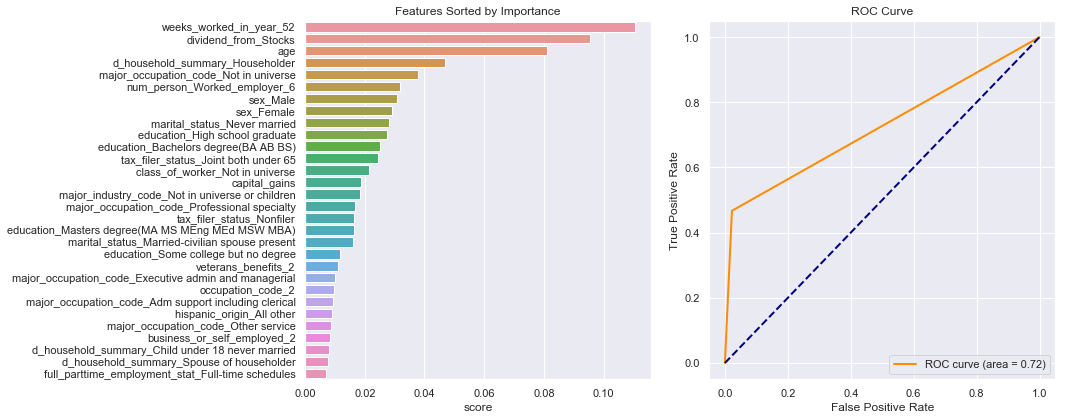

In [64]:
# # This section performs feature selection and is only ran after the model has been trained originally
# X_train_rf, X_val_rf, X_test_rf = select_features(X_train, X_val, X_test, importances_df['features'].iloc[:100])

# # Make Copies of Datasets
# X_train_rf = X_train.copy()
# X_val_rf = X_val.copy()
# X_test_rf = X_test.copy()

# # Define and Fit Model
# rfc = RandomForestClassifier(n_estimators = 50)
# rfc.fit(X_train_rf, y_train)
# rfc.feature_importances_

# Make Predictions
threshold = 0.3
pred_rfc_score = rfc.predict(X_val_rf)
pred_rfc = rfc.predict_proba(X_val_rf)
pred_rfc = (pred_rfc [:,1] >= threshold).astype('int')

# Evaluate Model w/ Confusion Matrix
print('RESULTS W/ THRESHOLD OF {}'.format(threshold), '\n')
confusion_mat = confusion_matrix(y_val, pred_rfc)
print('Confusion Matrix','\n', confusion_mat, '\n')
print('True Negatives = {}'.format(confusion_mat[0][0]))
print('False Negatives = {}'.format(confusion_mat[1][0]))
print('True Positives = {}'.format(confusion_mat[1][1]))
print('False Positives = {}'.format(confusion_mat[0][1]), '\n')

# Evaluate Model w/ Classification Report
print('Classification Report', '\n', '\n', classification_report(y_val, pred_rfc))

# PLOT CURVES
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6)

# Plot Most Important Features
importances_df = pd.DataFrame()
importances_df['features'] = X_train_rf.columns
importances_df['score'] = rfc.feature_importances_
importances_df.sort_values(by='score', axis=0, ascending=False, inplace=True)
sns.barplot(x=importances_df['score'][:30], y=importances_df['features'][:30].values, ax=axes[0])
axes[0].set(title='Features Sorted by Importance')

# Receiver Operator Characteristic Curve
fpr, tpr, _ = roc_curve(y_val, pred_rfc_score) # the predictions must be non-thresholded
roc_auc = auc(fpr, tpr)
lw = 2
axes[1].plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# axes[0].xlim([0.0, 1.0])
# axes[0].ylim([0.0, 1.05])
axes[1].set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC Curve')
axes[1].legend(loc="lower right")
plt.tight_layout() # to leave some space between plots

#### Analysis:
There are several things to note from the results above:
1. Accuracy (or precision) is considerably high at 0.94, as expected because of the imbalance. But notice the low precision on the the "1" category. It has an even lower recall. Since precision and recall are competing values, moving the threshold to increase one tends to decrease the other, and vice-versa. The rate is not proportional though (as seen from the ROC Curve) so depending on what we would rather focus on (precision vs recall) we can modify the threshold accordingly.
2. The F1 score for the minority class, 0.54, might be enough depending on how important it is to get the minority class correctly.
3. From the Feature Importance graph we see which features the model identified as the most relevant to predict the target classes. We used this information to limit the number of features to 100, from the ~160 original ones resulting from expanding them by one-hot encoding PLUS reducing them by removing those with a low variance.
4. The Area Under the Curve (AUC) for the ROC Curve is 0.72, a not-terrible value, and it's definitely better than a naive classifier, but we might be able to improve upon. 

Let's now try Gradient Boost Classifier and compare the results.

### Model B: Ensemble Gradient Boosting Classifier

RESULTS W/ THRESHOLD OF 0.6 

Confusion Matrix 
 [[34710  2346]
 [  813  1656]] 

True Negatives = 34710
False Negatives = 813
True Positives = 1656
False Positives = 2346 

Classification Report 
              precision    recall  f1-score   support

          0       0.98      0.94      0.96     37056
          1       0.41      0.67      0.51      2469

avg / total       0.94      0.92      0.93     39525



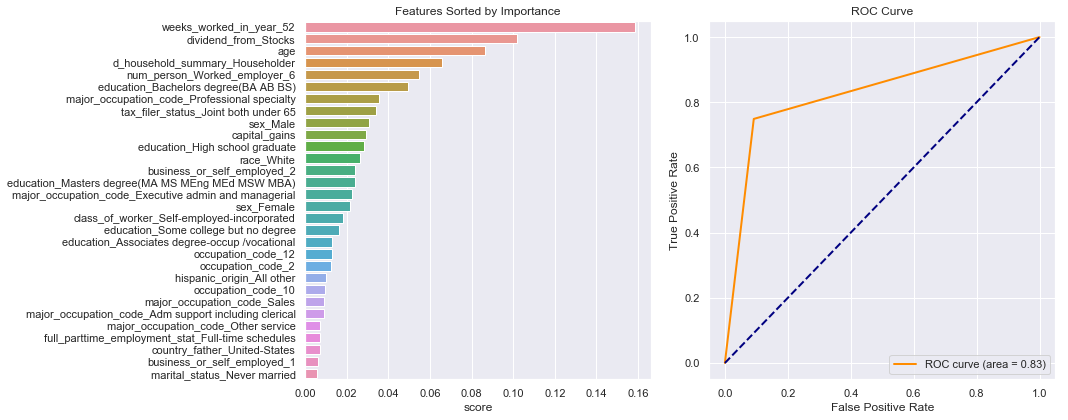

In [69]:
# # This section performs feature selection and is only ran after the model has been trained originally
# X_train_egb, X_val_egb, X_test_egb = select_features(X_train, X_val, X_test, importances_df['features'].iloc[:100])

# # Make Copies of Datasets
# X_train_egb = X_train.copy()
# X_val_egb = X_val.copy()
# X_test_egb = X_test.copy()

# # Define and Fit Model
# egb_params = [{'learning_rate': [0.1], 'max_depth':[4]}] # from previous run
# egb = GradientBoostingClassifier(n_estimators=50)
# egb_model = GridSearchCV(egb, param_grid=egb_params, cv=5, refit=True, verbose=1)
# egb_model.fit(X_train_egb, y_train)
# best_score = egb_model.best_score_
# best_params = egb_model.best_params_
# print(' The Best Score :', best_score, '\n', 'The Best Params : ', best_params, '\n')

# Predict on Validation Set
threshold = 0.6
pred_egb_score = egb_model.predict(X_val_egb)
pred_egb = egb_model.predict_proba(X_val_egb)
pred_egb = (pred_egb [:,1] >= threshold).astype('int')


# Evaluate Model w/ Confusion Matrix
print('RESULTS W/ THRESHOLD OF {}'.format(threshold), '\n')
confusion_mat = confusion_matrix(y_val, pred_egb)
print('Confusion Matrix','\n', confusion_mat, '\n')
print('True Negatives = {}'.format(confusion_mat[0][0]))
print('False Negatives = {}'.format(confusion_mat[1][0]))
print('True Positives = {}'.format(confusion_mat[1][1]))
print('False Positives = {}'.format(confusion_mat[0][1]), '\n')

# Evaluate Model w/ Classification Report
print('Classification Report', '\n', classification_report(y_val, pred_egb))

# PLOT CURVES
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6)

# Plot Most Important Feature
importances_df = pd.DataFrame()
importances_df['features'] = X_train_egb.columns
importances_df['score'] = egb_model.best_estimator_.feature_importances_
importances_df.sort_values(by='score', axis=0, ascending=False, inplace=True)
sns.barplot(x=importances_df['score'][:30], y=importances_df['features'][:30].values, ax=axes[0])
axes[0].set(title='Features Sorted by Importance')

# Receiver Operator Characteristic Curve
fpr, tpr, _ = roc_curve(y_val, pred_egb_score) # the predictions must be non-thresholded
roc_auc = auc(fpr, tpr)
lw = 2
axes[1].plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# axes[0].xlim([0.0, 1.0])
# axes[0].ylim([0.0, 1.05])
axes[1].set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC Curve')
axes[1].legend(loc="lower right")
plt.tight_layout() # to leave some space between plot

#### Analysis:

The results from our Gradient Boosting Classifier are almost identical to those of our Random Forests model. The major difference is the ROC AUC, which increased to 0.83. 

In imbalanced datasets AUC is not the most appropriate indicator of model performance. F1 scores tend to be a better basis to determine which model is best because it's more "fair" to the minority class. Although only a couple of hyperparameters were tried, GB might provide better results with different hyper parameter values, as it might be overfitting to the training set.

### Predict and Evaluate on Test Set
Lastly, let's test one of our models in the actual test set (so far we have been testing on the validation set). We will choose Random Forests since it's a simpler model and performs slightly better than GB.

In [96]:
# Make Predictions
threshold = 0.3
pred_final_score = rfc.predict(X_test_rf) # X_test was converted to X_test_rf which only includes the top 100 features
pred_final = rfc.predict_proba(X_test_rf)
pred_final = (pred_final [:,1] >= threshold).astype('int')

# Evaluate Model w/ Confusion Matrix
print('RESULTS W/ THRESHOLD OF {}'.format(threshold), '\n')
confusion_mat = confusion_matrix(y_test, pred_final)
print('Confusion Matrix','\n', confusion_mat, '\n')
print('True Negatives = {}'.format(confusion_mat[0][0]))
print('False Negatives = {}'.format(confusion_mat[1][0]))
print('True Positives = {}'.format(confusion_mat[1][1]))
print('False Positives = {}'.format(confusion_mat[0][1]), '\n')

# Evaluate Model w/ Classification Report
print('Classification Report', '\n', '\n', classification_report(y_test, pred_final))

RESULTS W/ THRESHOLD OF 0.3 

Confusion Matrix 
 [[92246  1330]
 [ 4264  1922]] 

True Negatives = 92246
False Negatives = 4264
True Positives = 1922
False Positives = 1330 

Classification Report 
 
              precision    recall  f1-score   support

          0       0.96      0.99      0.97     93576
          1       0.59      0.31      0.41      6186

avg / total       0.93      0.94      0.94     99762



The final predictions on our test set show a good averaged precision, recall and f1-scores. However, while the precision for the minority class increased, its recall and f1 scores were reduced considerably.

Overall the model is considerably better than no model at all, but its results leave big room for improvement. Some things to try would be:
1. Perform a more rigurous feature engineering process to normalize each feature independently.
2. Try a different set of models: SVC or Neural Networks.
3. Try some Principal Component Analysis (PCA) to reduce the number of dimensions in our dataset.
4. Explore a wider set of hyper-parameters on each model.

Lastly, the data pre-processing and model-fitting part of this analysis contains many building blocks that could be assembled into a pipeline to streamline the analysis. I decided to leave it as is to highlight all the variations of methods that can be combined when exploring which process results in the best model.

### I hope you found this useful! Thanks and if you did please kindly share. 